# 프로젝트명 : 뉴스기사 요약해보기

## 루브릭

|평가문항|상세기준|
|:-|:-|
|1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.|분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.|
|2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.|모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.|
|3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.|두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.|

## 텍스트 요약 이해하기

![img01](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-21-1.png)

### 추출적 요약(Extractive Summarization)

- 추출적 요약은 __단어 그대로 원문에서 문장들을 추출해서 요약하는 방식__이다. 가령, 10개의 문장으로 구성된 텍스트가 있다면, 그중 핵심적인 문장 3개를 꺼내와서 3개의 문장으로 구성된 요약문을 만드는 식이다. 하지만 꺼내온 3개의 문장이 원문에서 중요한 문장일 수는 있어도, 3개의 문장의 연결이 자연스럽지 않을 수는 있기 때문에 결과로 나온 문장들 간의 호응이 자연스럽지 않을 수 있느 문제점이 있다.  
  
  
- 딥 러닝보다는 주로 전통적인 머신 러닝 방식에 속하는 텍스트 랭크(TextRank)와 같은 알고리즘을 사용해서 이 방법을 사용하는데 __가장 대표적인 것이 네이버 뉴스 서비스에 있는 요약봇 기능__이다.  
  
  
- 원문을 구성하는 문장 중 어느 것이 요약문에 들어갈 핵심문장인지를 판별한다는 점에서 __문장 분류(Text Classification)__ 문제로 볼 수 있다.

### 추상적 요약(Abstrctive Summarization)

- __원문으로부터 내용이 요약된 새로운 문장을 생성해내는 것__이죠. 여기서 새로운 문장이라는 것은 결과로 나온 문장이 원문에 원래 없던 문장일 수도 있다는 것을 의미합니다.   
  
    
- 자연어 처리 분야 중 __자연어 생성(Natural Language Generation, NLG)의 영역__이다.

# Part1. 추상적 요약(Abstractive summarization)

## 1. 데이터 수집하기

In [1]:
# 패키지 불러오기
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# 데이터 다운(※ 출처 : https://github.com/sunnysai12345/News_Summary)

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플 수 :', (len(data)))

전체 샘플 수 : 98401


In [3]:
data.sample(10)

,headlines,text
80397,Harvard scientists create most advanced quantu...,A US-Russia research collaboration at Harvard ...
39072,"You always got my back, I got yours: Arjun on ...",Sonam Kapoor's cousin Arjun Kapoor shared a ph...
46500,Can't appear before ED as passport is suspende...,Billionaire jeweller Nirav Modi has told the E...
80763,Killer of Putin critic Nemtsov sentenced to 20...,A Russian court has handed prison sentences ra...
32369,I want audience to expect the unexpected from ...,Ranveer Singh said it is his constant endeavou...
64625,Tourist jailed for 3 months in Dubai for touch...,A British tourist has been sentenced to three ...
74588,Child care allowance for women with disabiliti...,The Centre has doubled the allowance for women...
6944,BeyoncÃÂ© arrives in India for Isha Ambani's ...,"American singer BeyoncÃÂ© arrived in Udaipur,..."
90879,Facebook CEO Mark Zuckerberg rides tractor on ...,Facebook Co-founder and CEO Mark Zuckerberg ha...
46774,"Pak, China behind rising B'desh immigrants in ...",Talking about rising Bangladeshi immigrants in...


## 2. 데이터 전처리 (1) 데이터 정리

### 중복 샘플과 Null값이 존재하는 샘플 제거

In [4]:
data.shape

(98401, 2)

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


Headlines는 아주 간단한 요약일 경우 Text가 달라도 중복될 수 있다.  
  
하지만 Text 자체가 중복이 되는 경우는 중복 샘플이므로 제거를 해줘야 한다.

In [6]:
# drop_duplicates()를 이용해 중복 샘플 제거하기
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플 수 :', len(data))

전체 샘플 수 : 98360


In [7]:
# isnull()을 이용해 데이터 프레임에 Null 값이 있는지 추가로 확인하기
data.isnull().sum()  # Null값이 발견되지 않았다.

headlines    0
text         0
dtype: int64

### 텍스트 정규화와 불용어 제거

많은 단어들 중에서는 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우가 있습니다.
이런 경우 기계가 굳이 이들을 마치 다른 단어로 간주하게 해서 연산량을 늘리는 것보다는 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법이므로 텍스트 정규화를 작업을 진행합니다.

In [8]:
# 텍스트 정규화
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


또한, 일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재하는데 이를 불용어(stopwords)라고 부릅니다. 때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법이라고 합니다. 여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거 해보겠습니다.

In [9]:
# 불용어 제거
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

다음으로 모든 영어 문자는 소문자로 만들고, 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 데이터 전처리를 진행합니다.

In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()  # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, 'lxml').text  # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)  # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence)  # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])  # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence)  # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence)  # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence)  # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
# 전처리 전, 후의 결과를 확인하기 위해서 
# 임의의 text와 summary를 만들어 함수를 호출해보겠습니다.

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


## 3. 데이터 전처리 (2) 훈련 데이터와 테스트 데이터 나누기

훈련 데이터 전체에 대해서 전처리를 수행해봅니다. 이때, Text의 경우에는 불용어를 제거하고, Summary의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행해야 해요. 먼저 Text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력하겠습니다.

### 멀티프로세싱을 통한 훈련 데이터 전처리

In [12]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    return texts

def preprocess_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

    text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
    pool = Pool(num_cores)

    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
    pool.close()
    pool.join()
    print(time.time() - start_time, " seconds")
    return processed_data

clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_headlines)

192.95278525352478  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

In [13]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [14]:
# Null값 확인
data.isnull().sum()  # Null값이 존재 하지 않음

headlines    0
text         0
dtype: int64

### 샘플의 최대 길이 설정

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


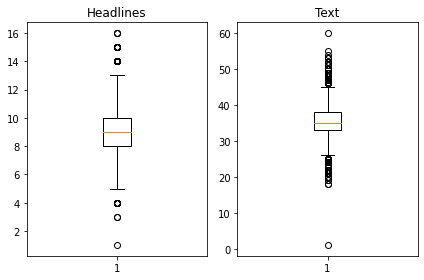

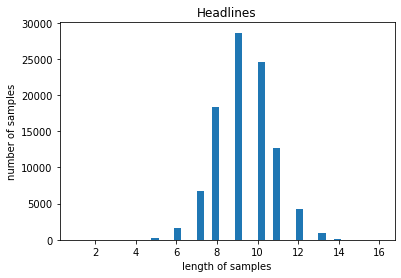

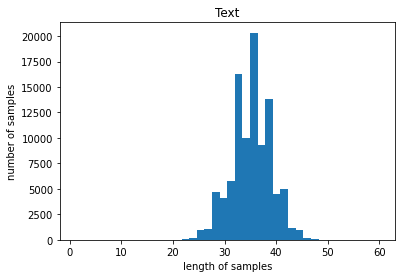

In [15]:
# text, headline의 최소, 최대, 평균 길이를 구하고, 길이 분포를 시각화 해줍니다.
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
# text의 최대 길이와 headlines의 적절한 최대 길이를 임의로 정해준다.
text_max_len = 40
headlines_max_len = 12

In [17]:
# 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇%가 해당하는지 계산하는 함수
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if (len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s'%(max_len, (cnt / len(nested_list))))

In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율 : 0.9238714924766165
전체 샘플 중 길이가 12 이하인 샘플의 비율 : 0.9880337535583571


In [19]:
# 정해진 길이보다 길면 제외하기
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 89775


### 시작 토큰과 종료 토큰 추가

![img1](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-21-4.png)

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가합니다. 여기서 __시작 토큰은 `sostoken`__, __종료 토큰은 `eostoken`__이라 임의로 명명하고 앞, 뒤로 추가하겠습니다. __디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 `decoder_input`__, __디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 `decoder_target`__이라고 이름을 정했어요. 두 개의 문장 모두 headlines 컬럼에 만들겠습니다.

In [20]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')  # ' eostoken' 앞에 summary와의 공백을 위해 공백 한칸 띄워주기
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [21]:
# 디코더의 입력과 레이블을 다시 Numpy 타입으로 저장해준다.
encoder_input = np.array(data['text'])  # 인코더의 입력
decoder_input = np.array(data['decoder_input'])  # 디코더의 입력
decoder_target = np.array(data['decoder_target'])  # 디코더의 레이블

### 훈련 데이터와 테스트 데이터 분리 작업

In [22]:
# encoder_input 크기와 형태가 같은 순서가 섞인 정수 시퀀스 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[51946 31687 30706 ... 14866 48491 79923]


In [23]:
# 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해주면 잘 섞인 샘플이 된다.
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [24]:
# 이렇게 섞인 데이터를 8:2 비율로 훈련 데이터와 테스트 데이터로 분리한다.
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17955


In [25]:
# 테스트 데이터의 개수를 이용해 전체 데이터를 양분한다. (: 표시의 위치에 주의)
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 71820
훈련 레이블의 개수 : 71820
테스트 데이터의 개수 : 17955
테스트 레이블의 개수 : 17955


## 4. 데이터 전처리 (3) 정수 인코딩

### 단어 집합(vocabulary) 생성 및 정수 인코딩

이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주는 작업을 합니다. 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업인 단어 집합(vocabulary) 만들기를 진행합니다.  
  
우선, 원문에 해당되는 __`encoder_input_train`__에 대해서 단어 집합을 만들게요.

In [26]:
# 토크나이저를 사용해 입력된 훈련 데이터로부터 단어 집합 만들기
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 현재 생성된 단어 집합은 __`src_tokenizer.word_index`__에 저장되어 있어요.  
이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행 하겠습니다.

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.

__`src_tokenizer.word_counts.items()`__에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있어요.

In [27]:
threshold = 7
total_cnt = len(src_tokenizer.word_index)  # 단어의 수
rare_cnt = 0  # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0  # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 65542
등장 빈도가 6번 이하인 희귀 단어의 수: 44568
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20974
단어 집합에서 희귀 단어의 비율: 67.99914558603643
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.6526311883504294


__`encoder_input_train`__에는 6만여 개의 단어가 있네요. 그 아래의 통계 정보들을 해석해볼까요?

등장 빈도가 threshold 값인 7회 미만, 즉, 6회 이하인 단어들은 단어 집합에서 68% 정도를 차지하네요. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.65%밖에 되지 않습니다.

그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다. 위에서 이를 제외한 단어 집합의 크기를 약 20,000개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 20,000개으로 제한해볼게요. 토크나이저를 정의할 때 num_words의 값을 정해줘서 단어 집합의 크기를 제한해봅니다.

In [28]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

__`texts_to_sequences()`__는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행해요.  
  
현재 단어 집합의 크기를 20,000으로 제한했기 때문에 이제 20,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않습니다.

In [29]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[37, 574, 16, 214, 139, 59, 68, 60, 121, 55, 18, 1792, 908, 3887, 1524, 288, 6098, 159, 1896, 139, 259, 2875, 60, 55, 1525, 3887, 1524, 830, 2236, 1088, 1492, 889, 3], [120, 28, 1153, 4220, 5876, 171, 4359, 7704, 3734, 11415, 1153, 22, 1479, 14, 19523, 899, 1162, 1241, 7349, 3216, 14, 1594, 6662, 34, 2433, 49, 1958, 1851, 1153, 14], [403, 9, 3465, 645, 1324, 3035, 150, 300, 61, 89, 4678, 4289, 236, 576, 206, 300, 735, 4517, 2654, 1435, 256, 530, 17396, 484, 4360, 1549, 78, 1, 474, 724, 746, 59]]


이제 더 이상 텍스트 데이터가 아니라 정수가 나오고 있어요.

headlines 데이터에 대해서도 동일한 작업을 수행할게요. 케라스의 토크나이저를 사용하여 __`decoder_input_train`__을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산해요.

In [30]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 이는 __`tar_tokenizer.word_index`__에 저장되어 있어요. __`tar_tokenizer.word_counts.items()`__에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.

In [31]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28799
등장 빈도가 5번 이하인 희귀 단어의 수: 18871
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9928
단어 집합에서 희귀 단어의 비율: 65.526580784055
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.922275571391327


In [32]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 987, 158, 50, 3431, 5, 5810, 311, 81, 127, 24, 42], [1, 1047, 3857, 8386, 52, 6, 4250, 2435, 63], [1, 146, 3432, 4724, 12, 533, 8, 407], [1, 5286, 4725, 107, 165, 6, 2773, 4251, 4, 26, 462], [1, 189, 966, 1850, 163, 988, 225, 13, 1464, 2639, 35]]
target
decoder  [[987, 158, 50, 3431, 5, 5810, 311, 81, 127, 24, 42, 2], [1047, 3857, 8386, 52, 6, 4250, 2435, 63, 2], [146, 3432, 4724, 12, 533, 8, 407, 2], [5286, 4725, 107, 165, 6, 2773, 4251, 4, 26, 462, 2], [189, 966, 1850, 163, 988, 225, 13, 1464, 2639, 35, 2]]


정상적으로 정수 인코딩 작업이 끝났어요. 현재 __`decoder_input_train`__과 __`decoder_target_train`__에는 더 이상 숫자 2,000이 넘는 숫자들은 존재하지 않아요. 그런데 다음 작업인 패딩 하기로 넘어가기 전에 한 가지 점검해야 할 것이 있어요.

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있어요. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높겠죠.

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와볼게요. 여기서 주의할 점은 요약문인 __`decoder_input`__에는 __`sostoken`__ 또는 __`decoder_target`__에는 __`eostoken`__이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않아요. 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 거예요. 길이 0이 된 __`decoder_input`__에는 __`sostoken`__, __`decoder_target`__에는 __`eostoken`__만 남아 있을 테니까요.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 __`drop_train`__과 __`drop_test`__에 라는 변수에 저장해볼게요. 이 샘플들은 모두 삭제할 거예요.

In [33]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 71820
훈련 레이블의 개수 : 71820
테스트 데이터의 개수 : 17955
테스트 레이블의 개수 : 17955


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### 패딩(Padding)

텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 진행합니다.  
  
아까 정해두었던 최대 길이로 패딩 해주고, 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰주겠습니다.

In [34]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 5. 모델 설계하기

### seq2seq

In [35]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

임베딩 벡터의 차원은 128로 정의하고, LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터인 hidden state의 크기를 256으로 정의합니다. hidden state는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수라고 이해하면 돼요. 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니에요.

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였어요. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있죠. 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줍니다.

In [36]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일해요. 하지만 LSTM의 입력을 정의할 때, __`initial_state`__의 인자값으로 __인코더의 hidden state와 cell state의 값을 넣어줘야 해요.__


In [37]:
# 디코더의 출력층 설계
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

디코더의 출력층에서는 Summary의 단어장인 __`tar_vocab`__의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 해요. 그렇기 때문에 Dense의 인자로 __`tar_vocab`__을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있어요.

지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq에요. 그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법인 __어텐션 메커니즘__을 활용해보겠습니다.

### 어텐션 매커니즘

In [38]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

이제 경로에 __`attention.py`__ 파일이 생겼으니, 어텐션 메커니즘을 사용할 준비가 되었어요. 설계한 디코더의 출력층을 다음과 같이 수정할게요.

In [39]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있어요.

## 6. 모델 훈련하기

In [40]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)  # val_loss가 증가하면 학습을 조기 종료함(EarlyStopping)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=30)

Epoch 1/30
281/281 [==============================] - 193s 647ms/step - loss: 5.9605 - val_loss: 5.1745
Epoch 2/30
281/281 [==============================] - 184s 656ms/step - loss: 5.1059 - val_loss: 4.7864
Epoch 3/30
281/281 [==============================] - 186s 662ms/step - loss: 4.7308 - val_loss: 4.5182
Epoch 4/30
281/281 [==============================] - 186s 661ms/step - loss: 4.4294 - val_loss: 4.3109
Epoch 5/30
281/281 [==============================] - 184s 653ms/step - loss: 4.2110 - val_loss: 4.1798
Epoch 6/30
281/281 [==============================] - 182s 647ms/step - loss: 4.0351 - val_loss: 4.0833
Epoch 7/30
281/281 [==============================] - 182s 647ms/step - loss: 3.8880 - val_loss: 3.9916
Epoch 8/30
281/281 [==============================] - 180s 642ms/step - loss: 3.7600 - val_loss: 3.9145
Epoch 9/30
281/281 [==============================] - 181s 643ms/step - loss: 3.6311 - val_loss: 3.8513
Epoch 10/30
281/281 [==============================] - 183s 650m

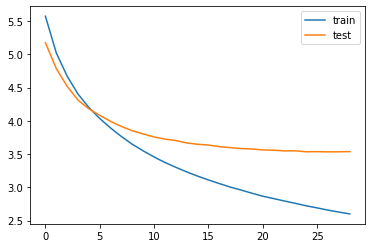

In [41]:
# 훈련 데이터와 검증 데이터의 손실이 줄어드는 과정 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 7. 인퍼런스 모델 구현하기

In [42]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [43]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [44]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [45]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 8. 모델 테스트 하기

In [46]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

### 요약 결과 확인

In [54]:
for i in range(20):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : supreme court tuesday allowed tamil nadu kerala karnataka andhra pradesh choose time bursting firecrackers diwali subject limit two hours submitted diwali celebrated morning southern parts country states also allowed burst crackers 
실제 요약 : southern states can pick their hours for firecrackers sc 
예측 요약 :  sc issues notice to kerala over andhra state


원문 : actress sharmila tagore filed complaint behalf bhopal royal family occupants prime residential property bhopal claiming ownership land following complaint district administration issued notices occupants furnish replies sharmila alleged occupants property also stole precious 
실제 요약 : sharmila files complaint to claim royal property in bhopal 
예측 요약 :  malayalam actress molested at mumbai airport


원문 : girl kerala filed complaint mother vhp rss workers allegedly holding captive years even giving electric shocks dating muslim man reportedly girl claimed given tablets day injections keep unconscious captivity 
실제 요약 : girl given 

# Part 2. 추출적 요약(Extractive summarization)

In [48]:
import requests
from summa.summarizer import summarize

In [49]:
# 데이터 다운(※ 출처 : https://github.com/sunnysai12345/News_Summary)

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플 수 :', (len(data)))

전체 샘플 수 : 98401


In [50]:
# text 컬럼의 문장을 summary 컬럼으로 요약한다.
data['summary'] = data['text'].apply(lambda x: summarize(x, ratio=0.5))

In [51]:
data.sample(10)

,headlines,text,summary
29138,NDA govt ministers have visited 186 of 192 cou...,Talking about NDA government's four years in p...,Talking about NDA government's four years in p...
22576,Pakistan cricketers' salaries increased by 25%...,The Pakistan cricketers across the board's cen...,The Pakistan cricketers across the board's cen...
2488,Designer Anamika accused of copying concept; S...,Sonam Kapoor and her sister Rhea defended desi...,Sonam Kapoor and her sister Rhea defended desi...
25501,TDP seeks support for no-trust motion against ...,A day before the Monsoon Session of the Parlia...,A day before the Monsoon Session of the Parlia...
25102,One MP came running to me saying Utho Utho Uth...,Taking a dig at Congress President Rahul Gandh...,Taking a dig at Congress President Rahul Gandh...
89807,"Filing FIR against you, bless me: Kapil Mishra...",Sacked Delhi Minister Kapil Mishra on Tuesday ...,But I am ready to fight...
80312,Iran jails US dual national for 10 years over ...,An Iranian court has sentenced a US dual natio...,An Iranian court has sentenced a US dual natio...
94638,What is a Tomahawk cruise missile?,The Tomahawk cruise missile is a long-range US...,Tomahawk missiles can be guided by GPS to targ...
59024,European Games 2019 to include new mixed gende...,A new mixed gender team competition is set to ...,"Each team will feature nine women, eight men, ..."
94815,"Boeing, JetBlue back Indian-origin man's aircr...","Hybrid electric aircraft startup Zunum Aero, f...","Hybrid electric aircraft startup Zunum Aero, f..."


### 요약 결과 확인

In [53]:
# 실제 요약과 추출된 요약 비교
for i in range(20):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("추출 요약 :", data['summary'][i])
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출 요약 : Users get one CRED coin per rupee of bill pai

# Part 3. 추상적 요약 vs. 추출적 요약 결과 비교

### 추상적 요약 방식
- 원문으로부터 핵심내용을 새로운 문장으로 생성해내기 때문에 문법적인 오류가 많이 보였다. 텍스트 불용화와 정규화가 오히려 문장을 요약하는데 좋지 못한 영향을 준 것이 아닌 가 생각해본다. 
  

### 추출적 요약 방식
- 원문에서 문장을 그대로 추출해서 요약해주는 방식이기 때문에 추상적 요약과 비교 했을 때 상대적으로 요약문의 문법 완성도가 높았던 반면, 요약한 문장 중 핵심적인 내용이 아닌 경우가 종종 보였다. 동일한 방식을 사용해서 꽤나 정확한 문장들만 캐치하는 네이버 뉴스 요약봇의 기술 완성도에 대단함을 느꼈다.

# 회고

- 모델을 돌리는데 시간이 오래걸려서 다양한 방법을 시도해보지 못한 것이 아쉬웠다. 시간이 된다면 문장 최대길이, Voca 크기 등을 바꿔보면서 결과 값이 어떻게 나오는지 찾아보면 좋을 것 같다.